## Here we will try our best shot to predict the goals with our features

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/Master_UdeM/IFT-6758/Project/ift6758-project-main

/content/gdrive/MyDrive/Master_UdeM/IFT-6758/Project/ift6758-project-main


In [3]:
#!git clone https://GIT_TOKEN@github.com/M0rph3e/ift6758-project-main.git #not anymore
! git pull

Already up to date.


In [4]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


In [5]:
!pip install comet_ml pandas_profiling

In [6]:
! git branch

  best_shot_trial
  fengineering2
* main


# Real **** starts from here

In [7]:
from ift6758.features.feature_engineering2 import SeasonDataSetTwo
from ift6758.data.data_acquisition import Season
from ift6758.visualizations.simple_visualization import Utilities 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import random
import pandas as pd
import pickle
import sys
import json

import warnings
warnings.filterwarnings("ignore")

In [8]:
train_years = [2015,2016,2017]
valid_years = [2018]
test_years=[2019]


train_dataset = SeasonDataSetTwo(train_years)
valid_dataset = SeasonDataSetTwo(valid_years)
train_df = train_dataset.get_features_2()
valid_df = valid_dataset.get_features_2()

File with all events already Exists, loading from ../ift6758/data/PICKLE//2015_clean_all_events.pkl
File already Exists, loading from ../ift6758/data/PICKLE//2015_period_info.pkl
File with all events already Exists, loading from ../ift6758/data/PICKLE//2016_clean_all_events.pkl
File already Exists, loading from ../ift6758/data/PICKLE//2016_period_info.pkl
File with all events already Exists, loading from ../ift6758/data/PICKLE//2017_clean_all_events.pkl
File already Exists, loading from ../ift6758/data/PICKLE//2017_period_info.pkl
File with all events already Exists, loading from ../ift6758/data/PICKLE//2018_clean_all_events.pkl
File already Exists, loading from ../ift6758/data/PICKLE//2018_period_info.pkl


In [9]:
test_data = SeasonDataSetTwo(test_years)
test_df = test_data.get_features_2()

File with all events already Exists, loading from ../ift6758/data/PICKLE//2019_clean_all_events.pkl
File already Exists, loading from ../ift6758/data/PICKLE//2019_period_info.pkl


In [12]:
train_df.columns

Index(['result.penaltySeverity', 'result.penaltyMinutes', 'gamePk',
       'team.name', 'gamePeriod', 'coordinatesX', 'coordinatesY', 'shotType',
       'emptyNet', 'result.strength.name', 'gameSeconds', 'shotDistance',
       'shotAngle', 'isGoal', 'lastEventType', 'lastEventCoordinatesX',
       'lastEventCoordinatesY', 'timeFromLastEvent', 'distanceFromLastEvent',
       'rebound', 'speed', 'changeInShotAngle', 'angleSpeed'],
      dtype='object')

# Export the data csv to comet (do not execute for now)

In [16]:
from comet_ml import Experiment
import os



exp = Experiment(
    api_key=os.environ.get('COMET_API_KEY'),
    project_name='milestone-2',
    workspace='morph-e',
    log_code=True,
    log_graph=True
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/morph-e/milestone-2/691408bba0b8465cb99e9066082bf528



In [19]:
exp.log_dataframe_profile(
train_df, 
name='train_set_from_FE2',  # keep this name
dataframe_format='csv'  # ensure you set this flag!
)

exp.log_dataframe_profile(
valid_df, 
name='valid_set_from_FE2',  # keep this name
dataframe_format='csv'  # ensure you set this flag!
)

exp.log_dataframe_profile(
test_df, 
name='test_set_from_FE2',  # keep this name
dataframe_format='csv'  # ensure you set this flag!
)


COMET WARNING: unable to profile dataframe; ignoring
COMET WARNING: unable to profile dataframe; ignoring
COMET WARNING: unable to profile dataframe; ignoring


{'dataframe': {'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=0a61cc7219ed45259b111b186de629c9&experimentKey=691408bba0b8465cb99e9066082bf528',
  'assetId': '0a61cc7219ed45259b111b186de629c9',
  'web': 'https://www.comet.ml/api/asset/download?assetId=0a61cc7219ed45259b111b186de629c9&experimentKey=691408bba0b8465cb99e9066082bf528'},
 'profile': None}

# Split and shuffle Data

In [36]:
random.seed(42)

In [37]:
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)
valid_df = valid_df.sample(frac=1)

In [38]:
train_df.head()

,result.penaltySeverity,result.penaltyMinutes,gamePk,team.name,gamePeriod,coordinatesX,coordinatesY,shotType,emptyNet,result.strength.name,gameSeconds,shotDistance,shotAngle,isGoal,lastEventType,lastEventCoordinatesX,lastEventCoordinatesY,timeFromLastEvent,distanceFromLastEvent,rebound,speed,changeInShotAngle,angleSpeed
192948,NaN,NaN,2017020520,Minnesota Wild,3,-82.0,2.0,Wrist Shot,0,NaN,391.0,7.280110,15.945396,0,Shot,-65.0,26.0,3.0,29.410882,True,9.803627,31.345214,10.448405
127034,NaN,NaN,2016020787,Buffalo Sabres,3,-44.0,-27.0,Snap Shot,0,NaN,1077.0,52.478567,-30.963757,0,Faceoff,-69.0,22.0,31.0,55.009090,False,1.774487,0.000000,0.000000
103702,NaN,NaN,2016020402,Nashville Predators,2,-36.0,2.0,Slap Shot,0,NaN,162.0,53.037722,2.161079,0,Shot,-37.0,-19.0,9.0,21.023796,True,2.335977,22.232605,2.470289
181640,NaN,NaN,2017020342,Columbus Blue Jackets,2,-39.0,19.0,Slap Shot,0,NaN,636.0,53.488316,20.806791,0,Faceoff,-69.0,22.0,4.0,30.149627,False,7.537407,0.000000,0.000000
239034,NaN,NaN,2017021232,Montréal Canadiens,2,78.0,-7.0,Backhand,0,NaN,9.0,13.038405,32.471192,0,Faceoff,0.0,0.0,9.0,78.313473,False,8.701497,0.000000,0.000000


In [39]:
features = ['gameSeconds','timeFromLastEvent','gamePeriod','shotType', 'shotAngle','coordinatesX','coordinatesY', 'shotDistance','lastEventCoordinatesX','lastEventCoordinatesY','distanceFromLastEvent', 'rebound','speed','changeInShotAngle','angleSpeed']
label = ['isGoal']

In [40]:
train_df[features].isna().any()
valid_df[features].isna().any()
valid_df[features].isna().any()

gameSeconds              False
timeFromLastEvent        False
gamePeriod               False
shotType                 False
shotAngle                False
coordinatesX             False
coordinatesY             False
shotDistance             False
lastEventCoordinatesX    False
lastEventCoordinatesY    False
distanceFromLastEvent    False
rebound                  False
speed                    False
changeInShotAngle        False
angleSpeed               False
dtype: bool

### Replace inf with nan (annoying in normalization)

In [54]:
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
valid_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [55]:
#drop rows with nan
train_df = train_df[train_df['shotType'].notna()]
valid_df = train_df[train_df['shotType'].notna()]
test_df = train_df[train_df['shotType'].notna()]

train_df = train_df[train_df['shotAngle'].notna()]
valid_df = train_df[train_df['shotAngle'].notna()]
test_df = train_df[train_df['shotAngle'].notna()]

train_df = train_df[train_df['shotDistance'].notna()]
valid_df = train_df[train_df['shotDistance'].notna()]
test_df = train_df[train_df['shotDistance'].notna()]

train_df = train_df[train_df['speed'].notna()]
valid_df = train_df[train_df['speed'].notna()]
test_df = train_df[train_df['speed'].notna()]

train_df = train_df[train_df['changeInShotAngle'].notna()]
valid_df = train_df[train_df['changeInShotAngle'].notna()]
test_df = train_df[train_df['changeInShotAngle'].notna()]

train_df = train_df[train_df['coordinatesX'].notna()]
valid_df = train_df[train_df['coordinatesX'].notna()]
test_df = train_df[train_df['coordinatesX'].notna()]

train_df = train_df[train_df['coordinatesY'].notna()]
valid_df = train_df[train_df['coordinatesY'].notna()]
test_df = train_df[train_df['coordinatesY'].notna()]

train_df = train_df[train_df['lastEventCoordinatesY'].notna()]
valid_df = train_df[train_df['lastEventCoordinatesY'].notna()]
test_df = train_df[train_df['lastEventCoordinatesY'].notna()]

train_df = train_df[train_df['lastEventCoordinatesX'].notna()]
valid_df = train_df[train_df['lastEventCoordinatesX'].notna()]
test_df = train_df[train_df['lastEventCoordinatesX'].notna()]

train_df = train_df[train_df['angleSpeed'].notna()]
valid_df = train_df[train_df['angleSpeed'].notna()]
test_df = train_df[train_df['angleSpeed'].notna()]



In [56]:
train_df[features].isna().any()
valid_df[features].isna().any()
valid_df[features].isna().any()

gameSeconds              False
timeFromLastEvent        False
gamePeriod               False
shotType                 False
shotAngle                False
coordinatesX             False
coordinatesY             False
shotDistance             False
lastEventCoordinatesX    False
lastEventCoordinatesY    False
distanceFromLastEvent    False
rebound                  False
speed                    False
changeInShotAngle        False
angleSpeed               False
dtype: bool

In [87]:
X_train = train_df[features]
y_train = train_df[label]

X_valid = valid_df[features]
y_valid = valid_df[label]

X_test = test_df[features]
y_test = test_df[label]

X_train, y_train, X_valid, y_valid

(        gameSeconds  timeFromLastEvent  ...  changeInShotAngle angleSpeed
 192948        391.0                3.0  ...          31.345214  10.448405
 127034       1077.0               31.0  ...           0.000000   0.000000
 103702        162.0                9.0  ...          22.232605   2.470289
 181640        636.0                4.0  ...           0.000000   0.000000
 239034          9.0                9.0  ...           0.000000   0.000000
 ...             ...                ...  ...                ...        ...
 2031           22.0                5.0  ...           0.000000   0.000000
 9307          102.0               11.0  ...           0.000000   0.000000
 153896        456.0                5.0  ...           0.000000   0.000000
 49353         214.0                5.0  ...           0.000000   0.000000
 75161         376.0               38.0  ...           0.000000   0.000000
 
 [238046 rows x 15 columns],         isGoal
 192948       0
 127034       0
 103702       0
 18164

### One Hot encode the shot type (I want to refer on the fact that the shot type affect the goal)

In [102]:
X_train['shotType'].unique()

array(['Wrist Shot', 'Snap Shot', 'Slap Shot', 'Backhand', 'Tip-In',
       'Wrap-around', 'Deflected'], dtype=object)

In [103]:
dum_train = pd.get_dummies(X_train['shotType'], prefix='Shot',dtype=int)
dum_valid = pd.get_dummies(X_valid['shotType'], prefix='Shot',dtype=int)
dum_test = pd.get_dummies(X_test['shotType'], prefix='Shot',dtype=int)

In [104]:
X_train = pd.concat([X_train, dum_train], axis=1)
X_valid = pd.concat([X_valid, dum_valid], axis=1)
X_test = pd.concat([X_test, dum_test], axis=1)

In [105]:
#check if no nans
X_train.isna().any(), X_valid.isna().any(), X_test.isna().any()

(gameSeconds              False
 timeFromLastEvent        False
 gamePeriod               False
 shotType                 False
 shotAngle                False
 coordinatesX             False
 coordinatesY             False
 shotDistance             False
 lastEventCoordinatesX    False
 lastEventCoordinatesY    False
 distanceFromLastEvent    False
 rebound                  False
 speed                    False
 changeInShotAngle        False
 angleSpeed               False
 Shot_Backhand            False
 Shot_Deflected           False
 Shot_Slap Shot           False
 Shot_Snap Shot           False
 Shot_Tip-In              False
 Shot_Wrap-around         False
 Shot_Wrist Shot          False
 dtype: bool, gameSeconds              False
 timeFromLastEvent        False
 gamePeriod               False
 shotType                 False
 shotAngle                False
 coordinatesX             False
 coordinatesY             False
 shotDistance             False
 lastEventCoordinatesX    F

In [106]:
X_train = X_train.drop(columns='shotType')
X_valid = X_valid.drop(columns='shotType')
X_test = X_test.drop(columns='shotType')

## Do the same for gamePeriod

In [107]:
dum_train = pd.get_dummies(X_train['gamePeriod'], prefix='Period',dtype=int)
dum_valid = pd.get_dummies(X_valid['gamePeriod'], prefix='Period',dtype=int)
dum_test = pd.get_dummies(X_test['gamePeriod'], prefix='Period',dtype=int)

X_train = pd.concat([X_train, dum_train], axis=1)
X_valid = pd.concat([X_valid, dum_valid], axis=1)
X_test = pd.concat([X_test, dum_test], axis=1)

#check if no nans
X_train.isna().any(), X_valid.isna().any(), X_test.isna().any()

(gameSeconds              False
 timeFromLastEvent        False
 gamePeriod               False
 shotAngle                False
 coordinatesX             False
 coordinatesY             False
 shotDistance             False
 lastEventCoordinatesX    False
 lastEventCoordinatesY    False
 distanceFromLastEvent    False
 rebound                  False
 speed                    False
 changeInShotAngle        False
 angleSpeed               False
 Shot_Backhand            False
 Shot_Deflected           False
 Shot_Slap Shot           False
 Shot_Snap Shot           False
 Shot_Tip-In              False
 Shot_Wrap-around         False
 Shot_Wrist Shot          False
 Period_1                 False
 Period_2                 False
 Period_3                 False
 Period_4                 False
 Period_5                 False
 Period_6                 False
 dtype: bool, gameSeconds              False
 timeFromLastEvent        False
 gamePeriod               False
 shotAngle                F

In [108]:
#drop gamePeriod
X_train = X_train.drop(columns='gamePeriod')
X_valid = X_valid.drop(columns='gamePeriod')
X_test = X_test.drop(columns='gamePeriod')

# Change rebound feature

In [109]:
X_train['rebound'] = X_train['rebound'].astype(int)
X_valid['rebound'] = X_valid['rebound'].astype(int)
X_test['rebound'] = X_test['rebound'].astype(int)

In [110]:
X_test.head()

,gameSeconds,timeFromLastEvent,shotAngle,coordinatesX,coordinatesY,shotDistance,lastEventCoordinatesX,lastEventCoordinatesY,distanceFromLastEvent,rebound,speed,changeInShotAngle,angleSpeed,Shot_Backhand,Shot_Deflected,Shot_Slap Shot,Shot_Snap Shot,Shot_Tip-In,Shot_Wrap-around,Shot_Wrist Shot,Period_1,Period_2,Period_3,Period_4,Period_5,Period_6
192948,391.0,3.0,15.945396,-82.0,2.0,7.280110,-65.0,26.0,29.410882,1,9.803627,31.345214,10.448405,0,0,0,0,0,0,1,0,0,1,0,0,0
127034,1077.0,31.0,-30.963757,-44.0,-27.0,52.478567,-69.0,22.0,55.009090,0,1.774487,0.000000,0.000000,0,0,0,1,0,0,0,0,0,1,0,0,0
103702,162.0,9.0,2.161079,-36.0,2.0,53.037722,-37.0,-19.0,21.023796,1,2.335977,22.232605,2.470289,0,0,1,0,0,0,0,0,1,0,0,0,0
181640,636.0,4.0,20.806791,-39.0,19.0,53.488316,-69.0,22.0,30.149627,0,7.537407,0.000000,0.000000,0,0,1,0,0,0,0,0,1,0,0,0,0
239034,9.0,9.0,32.471192,78.0,-7.0,13.038405,0.0,0.0,78.313473,0,8.701497,0.000000,0.000000,1,0,0,0,0,0,0,0,1,0,0,0,0


# Normalize numerical data 

In [111]:
num = ['gameSeconds','timeFromLastEvent', 'shotAngle','coordinatesX','coordinatesY', 'shotDistance','lastEventCoordinatesX','lastEventCoordinatesY','distanceFromLastEvent','speed','changeInShotAngle','angleSpeed']

In [112]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train[num])

X_train[num] = scaler.transform(X_train[num])
X_valid[num] = scaler.transform(X_valid[num])
X_test[num] = scaler.transform(X_test[num])

In [113]:
X_test

,gameSeconds,timeFromLastEvent,shotAngle,coordinatesX,coordinatesY,shotDistance,lastEventCoordinatesX,lastEventCoordinatesY,distanceFromLastEvent,rebound,speed,changeInShotAngle,angleSpeed,Shot_Backhand,Shot_Deflected,Shot_Slap Shot,Shot_Snap Shot,Shot_Tip-In,Shot_Wrap-around,Shot_Wrist Shot,Period_1,Period_2,Period_3,Period_4,Period_5,Period_6
192948,-0.583891,-0.848700,0.413023,-1.295313,0.122758,-1.030121,-1.007487,1.128279,-0.707271,1,0.179790,1.158422,1.241567,0,0,0,0,0,0,1,0,0,1,0,0,0
127034,1.386286,1.045599,-0.872871,-0.696095,-1.391600,0.391072,-1.069321,0.955474,-0.152465,0,-0.616642,-0.363797,-0.232715,0,0,0,1,0,0,0,0,0,1,0,0,0
103702,-1.241574,-0.442779,0.035161,-0.569944,0.122758,0.408654,-0.574644,-0.815771,-0.889049,1,-0.560946,0.715886,0.115846,0,0,1,0,0,0,0,0,1,0,0,0,0
181640,0.119743,-0.781047,0.546286,-0.617250,1.010486,0.422822,-1.069321,0.955474,-0.691259,0,-0.045002,-0.363797,-0.232715,0,0,1,0,0,0,0,0,1,0,0,0,0
239034,-1.680987,-0.442779,0.866035,1.227712,-0.347215,-0.849061,-0.002674,0.005050,0.352625,0,0.070467,-0.363797,-0.232715,1,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2031,-1.643651,-0.713393,0.704134,0.518111,-1.443819,0.709636,1.063973,0.955474,-0.009363,0,0.429628,-0.363797,-0.232715,0,0,1,0,0,0,0,0,0,1,0,0,0
9307,-1.413893,-0.307472,0.888067,-0.901091,1.114924,-0.055526,1.404064,-1.506989,2.084929,0,0.634277,-0.363797,-0.232715,0,0,0,0,0,0,1,0,1,0,0,0,0
153896,-0.397213,-0.713393,1.424759,-1.011473,1.741556,0.042740,-1.069321,0.955474,-1.082827,0,-0.552948,-0.363797,-0.232715,0,0,0,0,0,0,1,0,1,0,0,0,0
49353,-1.092232,-0.713393,-0.706780,0.518111,1.376021,0.682327,1.063973,0.955474,-0.559659,0,-0.074076,-0.363797,-0.232715,0,0,1,0,0,0,0,0,1,0,0,0,0


# Try Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'n_estimators':[50,65,80,100,115,130,150],
     'max_depth': [5,6,7,8,9,10,11,12,13,14]
}

rf = RandomForestClassifier(criterion='entropy')
sh = HalvingGridSearchCV(rf,param_grid, cv=4)
model = sh.fit(X_train,y_train)

In [ ]:
model.best_estimator_

In [ ]:
y_pred_valid  = model.predict(X_valid)

In [ ]:
y_proba_val = model.predict_proba(X_valid)[:,1] # get the proba of having a goal (pred=1)

In [ ]:
score_ = model.score(X_valid,y_valid)
score_

# Export model on comet before plotting

In [ ]:
weights_dir = "../ift6758/models/weights"
experiment = "Random-forest-with-FE2"
predscore_val_dict={}

In [ ]:
!ls ..

In [ ]:
import joblib

predscore_val_dict[experiment]={}
predscore_val_dict[experiment]['true_valid_label']=y_valid
predscore_val_dict[experiment]['proba']=y_proba_val
predscore_val_dict[experiment]['prediction']=y_pred_valid

## Dumping model
filename=f"{weights_dir}/{experiment}.pkl"
joblib.dump(model,filename)

In [ ]:
exp.log_model("Random Forest", "../ift6758/models/weights/Random-forest-with-FE2.pkl")

{'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=c67d522e79cd4e61a3ead5de12207be8&experimentKey=61ab29d2969f46b3b444cf6aef7b24e6',
 'assetId': 'c67d522e79cd4e61a3ead5de12207be8',
 'web': 'https://www.comet.ml/api/asset/download?assetId=c67d522e79cd4e61a3ead5de12207be8&experimentKey=61ab29d2969f46b3b444cf6aef7b24e6'}

In [ ]:
exp.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/morph-e/milestone-2/61ab29d2969f46b3b444cf6aef7b24e6
COMET INFO:   Others:
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=https%3A%2F%2Fgithub.com%2FM0rph3e%2Fift6758-project-main%2Fblob%2Fbest_shot_trial%2Fnotebooks%2Ftry_your_best_shot.ipynb
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     git metadata        : 1
COMET INFO:     installed packages  : 1
COMET INFO:     model-element       : 1 (9.11 MB)
COMET INFO:     notebook            : 1
COMET INFO:     os packages         : 1
COMET INFO:     source_code         : 1
COMET INFO: ---------------------------
COMET INFO: Uploading 1 metrics, params and output messages


# Plotting

In [ ]:
# First we will switch branch, the plotting metrics are on main
!git checkout main

Switched to branch 'main'
Your branch is up to date with 'origin/main'.


In [ ]:
!git branch

  best_shot_trial
  fengineering2
* main


In [ ]:
!git pull

Already up to date.


              precision    recall  f1-score   support

           0       0.91      1.00      0.95    216808
           1       1.00      0.03      0.06     21238

    accuracy                           0.91    238046
   macro avg       0.96      0.52      0.51    238046
weighted avg       0.92      0.91      0.88    238046



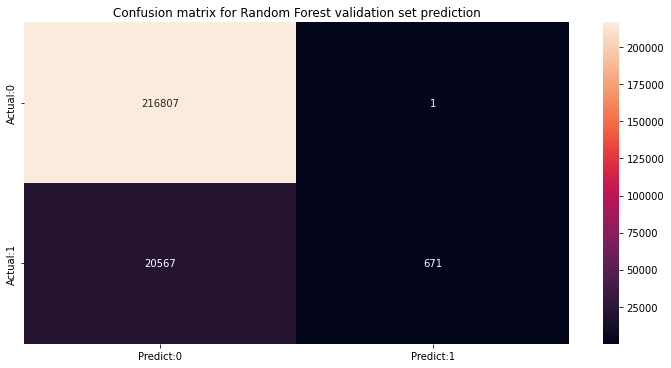

In [ ]:
from ift6758.metrics import plot_metrics

plot_metrics.plotConfusion(y_valid,y_pred_valid, title='Confusion matrix for Random Forest validation set prediction')

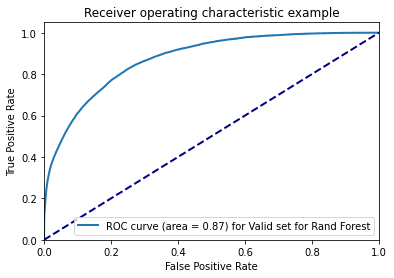

In [ ]:
plot_metrics.plot_roc([y_valid],[y_proba_val],["Valid set for Rand Forest"])

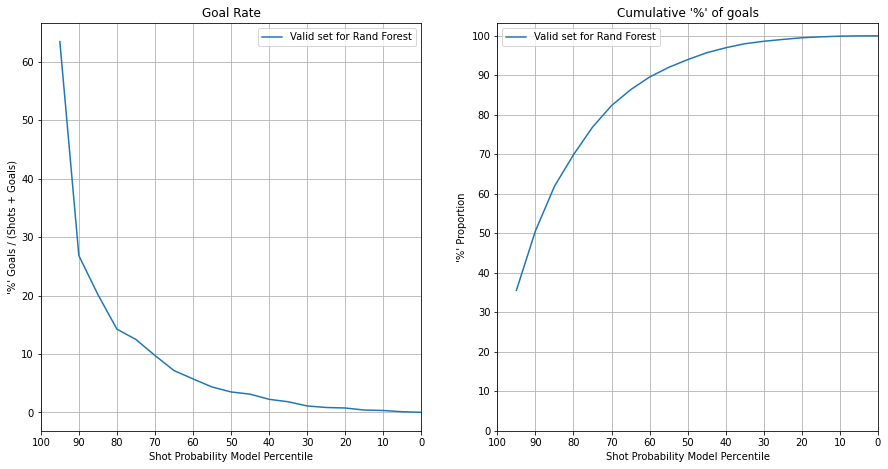

In [ ]:
plot_metrics.plot_percentile([y_valid],[y_proba_val],bin_width=5,plot_labels=["Valid set for Rand Forest"])

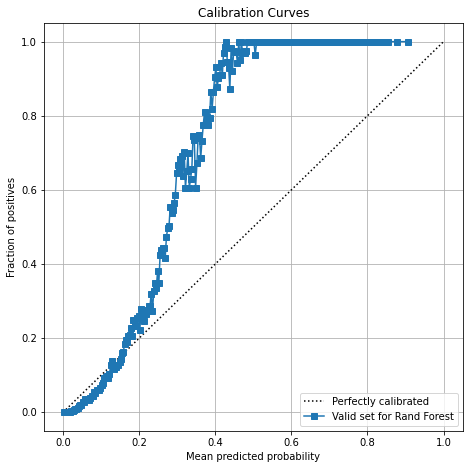

In [ ]:
plot_metrics.plot_calibration([y_valid],[y_proba_val],plot_labels=["Valid set for Rand Forest"])